# ZFOURGE SED Template Processing 
Using the generated ZFOURGE SED templates from the cdfs field, we explore how these SEDs will react in the UVJ colour space to see if the UVJ coordinates are still in the sample place.


In [273]:
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
import os
from astLib import astSED
import astropy.io.fits as fits
from carf import * # custom module for functions relating to the project

# So that we can change the helper functions without reloading the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [274]:
# We are attempting to read in a new set of SEDs that have been generated using a variation of Michael's ZFOURGE SED processing code.
# the SEDs are in the form of csvs, this can be explored in the zfourge/seds
# directory. The csvs are in the form of:
# Wavelength (microns), Flux Density (10^-19erg_s_cm^2_Angstrom)

zfourge_folderpath = os.path.join('Eazy Template Extractions', 'zfourgeSEDs')
# We would like to create a function to read this in
def read_zfourge_template(folder_path, name):
    """_summary_

    Args:
        folder_path (string): path to the folder where the SED templates are located
        name (string): name of the object
    
    Returns:
        df: Returns a dataframe containing the SED template
        objname: Returns the name of the object
    """
    folder_path = os.path.join(folder_path)
    files_in_folder = os.listdir(folder_path)

    for file in files_in_folder:
        # Find filepath and convert to df
        
        # get rid of units in the filename
        objname = file.split('_units')[0]
        objname = objname.split('_')[1]
        if objname == name:
            filepath = os.path.join(folder_path, file)
            df = pd.read_csv(filepath)
            
            print(df)
            # our wavelength is in microns, convert to Angstroms
            
            # for the first column, we want to convert to Angstroms
            df.iloc[:, 0] = df.iloc[:, 0] 
            # Name each of the columns appropriately
            df.columns = ['lambda (Angstroms)', 'Total Flux (erg/s/cm^2/Angstrom)']
            print(objname)
            return df, objname
        
    
    return None, None

df, objname = read_zfourge_template(zfourge_folderpath, '7544')

In [275]:
    
def read_zfourge_galaxy_templates(folder_path):
    """_summary_

        Args:
            folder_path (string): path to the folder where the SED templates are located
    
        Returns:
            df_list: Returns a list of dataframes containing the SED templates
            objname_list: Returns a list of the names of the objects
    """
    df_list = []
    objname_list = []
    folder_path = os.path.join(folder_path)
    files_in_folder = os.listdir(folder_path)
    i = 0
    
    for file in files_in_folder:

        # Find filepath and convert to df
        objname = file.split('_units')[0]
        objname = objname.split('_')[1]
        filepath = os.path.join(folder_path, file)
        df = pd.read_csv(filepath)
        
        
        # Make sure that the SED contains safe values
        # Where there are null values, remove them and interpolate
        df = df.dropna()
        df = df.interpolate()
        
        # Check if there are any bad values, i.e infinite values
        # If there is, drop them
        if np.any(np.isinf(df)):
            df = df.replace([np.inf, -np.inf], np.nan)
            df = df.dropna()
            df = df.interpolate()
        
        print(i)
        # Convert microns to angstroms    
        df.iloc[:, 0] = df.iloc[:, 0]
        
        # name each of the columns appropriately
        df.columns = ['lambda (Angstroms)', 'Total Flux (erg/s/cm^2/Angstrom)']
            
        # Append the dataframe to the list    
        df_list.append(df)
        objname_list.append(objname)
        
        
    return df_list, objname_list


In [276]:
# Filters
pb_U_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.U.dat')
pb_V_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.V.dat')
pb_J_path = os.path.join('datasets', 'Filters', '2MASS_2MASS.J.dat')

# Skirtor models
skirtor_folderpath = os.path.join('datasets', 'Templates', 'Skirtor')

In [277]:
# In addition also use astSED to create filters
pb_U = astSED.Passband(pb_U_path, normalise=False)
pb_V = astSED.Passband(pb_V_path, normalise=False)
pb_J = astSED.Passband(pb_J_path, normalise=False)

In [278]:
# Read in all the ZFOURGE templates
df_list, objname_list = read_zfourge_galaxy_templates(zfourge_folderpath)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


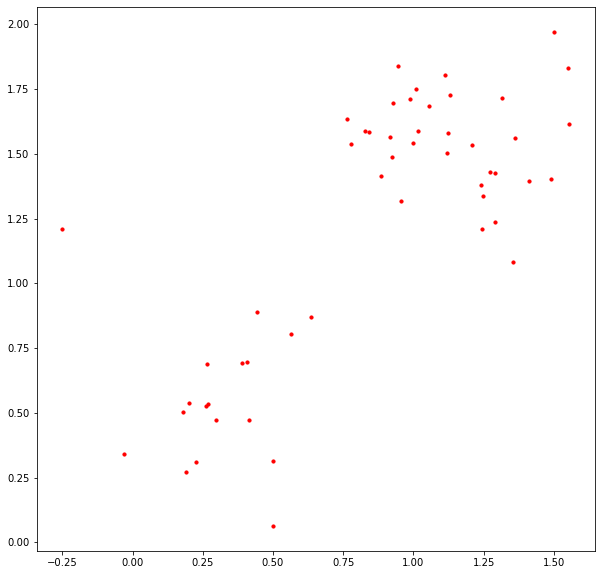

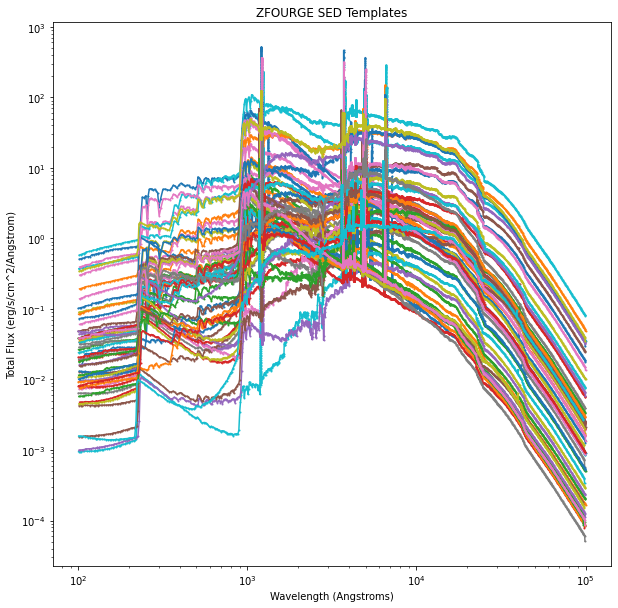

In [279]:
# Plot all of the SEDS

# for each sed, cut it so the wavelength is between 10^2 and 10^5
# then plot it
for i in range(len(df_list)):
    df_list[i] = df_list[i][(df_list[i]['lambda (Angstroms)'] > 10**2) & (df_list[i]['lambda (Angstroms)'] < 10**5)]


plt.figure(figsize=(10, 10))
for i in range(len(df_list)):
    plt.loglog(df_list[i].iloc[:, 0], df_list[i].iloc[:, 1], label=objname_list[i], marker='o', markersize=1)
#plt.legend()
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Total Flux (erg/s/cm^2/Angstrom)')
plt.title('ZFOURGE SED Templates')
plt.show()




We can see a very very clear trend of the seds now being alligned in their rest frame. The lyman break is clearly visible and the absorption and emission lines are also very clear. This is a very good sign that the SEDs are being generated correctly.

In [280]:
# We now have some SED's that can be put through my fitting code to see how the UVJ diagram looks,
# and to see if it behaves as expected

# We will need to convert the SEDs to a format that can be used by the fitting code
# We can attempt to use the composite code, without the need for the SED fitting code
uv_colours = []
vj_colours = []

# for better coverage, create an AGN SED, combine them at 0% and have a look
agn_df, params = create_type1_skirtor_agn(skirtor_folderpath)


# alpha list
alpha_list = np.linspace(0, 1, 11)

#print(df_list[0])
# create a composite set
composite_df = create_composite_sed(agn_df, df_list[0], 0) # This is just for one, with no agn juice added
print(composite_df)


There are  0  NaN values in the galaxy SED
      lambda (Angstroms)  Total Flux (erg/s/cm^2/Angstrom)
0             102.942380                          0.016053
1             104.712855                          0.016303
2             105.132645                          0.016363
3             107.322910                          0.018669
4             109.513170                          0.023041
...                  ...                               ...
2828        98342.830000                          0.000088
2829        98780.880000                          0.000087
2830        99218.940000                          0.000085
2831        99456.773100                          0.000085
2832        99656.984000                          0.000084

[2833 rows x 2 columns]


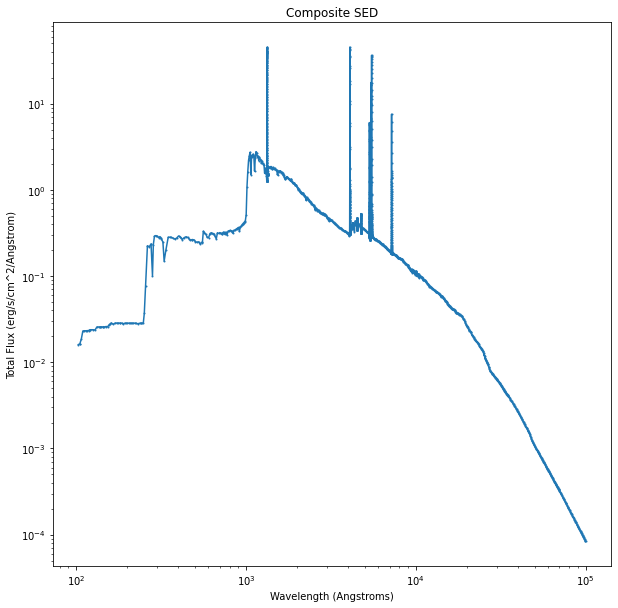

In [281]:
composite_df
# Plot this
plt.figure(figsize=(10, 10))
plt.loglog(composite_df.iloc[:, 0], composite_df.iloc[:, 1], label='Composite', marker='o', markersize=1)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Total Flux (erg/s/cm^2/Angstrom)')
plt.title('Composite SED')
plt.show()


In [282]:
uv_colours = []
vj_colours = []
bad_entries = []
new_objname_list = []
print(len(df_list))
for i, sed_data in enumerate(df_list):
    # Create an SED object using astSED    
    wl = sed_data['lambda (Angstroms)']
    fl = sed_data['Total Flux (erg/s/cm^2/Angstrom)']

    # We are using a restframe SED, so z = 0 - now atleast
    sed = astSED.SED(wavelength=wl, flux=fl, z=0.0)    
    
    


    # # Try to calc uvj, if math domain error occurs, if bad SED, delete it
    # uv = astSED.SED.calcColour(sed, pb_U, pb_V, magType='AB')
    # vj = astSED.SED.calcColour(sed, pb_V, pb_J, magType='AB')
    # uv_colours.append(uv)
    # vj_colours.append(vj)
    
    # We assume there will be some bad SEDs
    # Try to create UVJ colours, and if it fails, remove the SED
    # we expect a math domain error
    
    try:
        uv = astSED.SED.calcColour(sed, pb_U, pb_V, magType='AB')
        vj = astSED.SED.calcColour(sed, pb_V, pb_J, magType='AB')
        uv_colours.append(uv)
        vj_colours.append(vj)
        new_objname_list.append(objname_list[i])
    except:
        print('Bad SED')
        print(objname_list[i])
        bad_entries.append(i)
        del df_list[i]
        del objname_list[i]
        
        continue
    
    # 


60
Bad SED
11494
Bad SED
21410
Bad SED
26689
Bad SED
26828


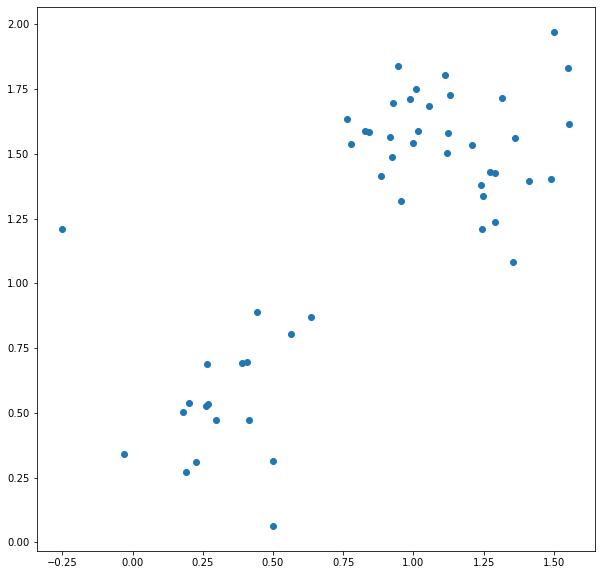

In [283]:
# print the number of bad entries
plt.figure(figsize=(10, 10))
plt.plot(vj_colours, uv_colours, 'o')
plt.show()


In [284]:
# create a dataframe with the IDs, UV and VJ colours
uv_vj_df = pd.DataFrame({'ID': new_objname_list, 'UV': uv_colours, 'VJ': vj_colours})

In [285]:
uv_vj_df

,ID,UV,VJ
0,10327,1.209127,-0.251252
1,10689,0.503645,0.180460
2,10895,0.535986,0.270191
3,11279,1.338716,1.247705
4,12945,0.697038,0.408018
5,13149,1.587005,1.016093
6,13596,0.536503,0.201734
7,13736,1.209055,1.242457
8,14832,0.271164,0.190627
9,15461,1.396436,1.410230


               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


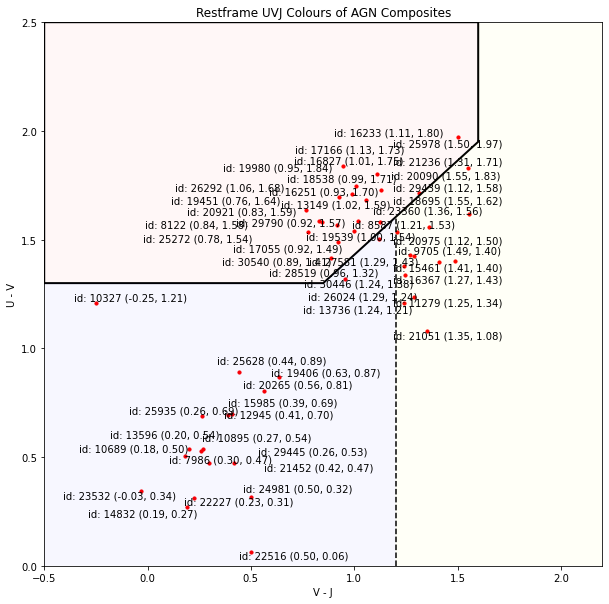

In [294]:
# Now we can plot these in UVJ space, including their relevant labels, and UV/VJ positions
from adjustText import adjust_text

plt.figure(figsize=(10, 10))

plt.scatter(vj_colours, uv_colours, c='r', s=10)

annotations = []

# Annotate points with text and adjust for collisions
texts = []
for i, txt in enumerate(new_objname_list):
    txt = f"id: {txt} ({vj_colours[i]:.2f}, {uv_colours[i]:.2f})"
    texts.append(plt.text(vj_colours[i], uv_colours[i], txt, ha='center'))

# Adjust text to avoid collisions
adjust_text(texts)

plt.ylabel('U - V')
plt.xlabel('V - J')
plt.title("Restframe UVJ Colours of AGN Composites")
plt.xlim([-0.5, 2.2])
plt.ylim([0, 2.5])

# Define paths for selections
path_quiescent = [[-0.5, 1.3], [0.85, 1.3], [1.6, 1.95], [1.6, 2.5], [-0.5, 2.5]]
path_sf = [[-0.5, 0.0], [-0.5, 1.3], [0.85, 1.3], [1.2, 1.60333], [1.2, 0.0]]
path_sfd = [[1.2, 0.0], [1.2, 1.60333], [1.6, 1.95], [1.6, 2.5], [2.2, 2.5], [2.2, 0.0]]

# Add patches for selections
plt.gca().add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
plt.gca().add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
plt.gca().add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

# Add vertical line
plt.axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)


plt.show()

